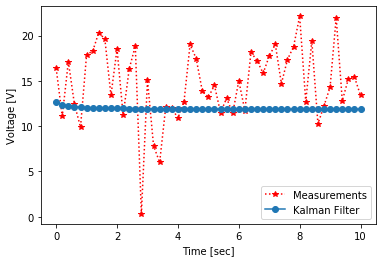

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def GetVolt():
    w = 0 + 4*np.random.randn()
    z = 14.4 + w
    return z
    
def SimpleKalman(z):
    A = np.matrix('[1]')
    H = np.matrix('[1]')  
    Q = np.matrix('[0]')
    R = np.matrix('[4]')
    x = np.matrix('[14]')
    P = np.matrix('[6]')
    while True:
        xp = A * x
        Pp = A * P * A.getT() + Q
        K = Pp * H.getT() * np.matrix.getI(H * Pp * H.getT() + R)
        x = xp + K * (z - H * xp)
        P = Pp - K * H * Pp
        volt = x
        yield volt

dt = 0.2
t  = np.arange(0, 10+dt, dt)

Nsamples = len(t)

Xsaved = np.zeros(Nsamples)
Zsaved = np.zeros(Nsamples)
volt = SimpleKalman(GetVolt())

for k in range(Nsamples):
    z = GetVolt()
    Xsaved[k] = next(volt)
    Zsaved[k] = z

fig, ax = plt.subplots()
ax.plot(t, Zsaved, 'r:*', label="Measurements")
ax.plot(t, Xsaved, 'o-', label="Kalman Filter") 
plt.xlabel("Time [sec]")
plt.ylabel("Voltage [V]")
plt.legend()

In [35]:
%%writefile SimpleKalman.cpp~



Writing SimpleKalman.cpp~


In [1]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
915725.v-qsvr-1            ...ub-singleuser u44807          00:00:05 R jupyterhub     
915728.v-qsvr-1            build_run.sh     u44807                 0 Q batch          

Waiting for Output ██████████ Done⬇

########################################################################
#      Date:           Fri 02 Jul 2021 07:18:00 AM PDT
#    Job ID:           915728.v-qsvr-1.aidevcloud
#      User:           u44807
# Resources:           neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

dpcpp SimpleKalman.cpp -o SimpleKalman -DMKL_ILP64  -I"/